In [5]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
data1=trX
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [4]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

# def batchnorm( x, g=None, b=None, eps=1e-8 ):
#     if x.ndim == 4:
#         m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
#         v = tensor.mean(tensor.sqr(x - m), 
#                           axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

#     elif x.ndim == 2:
#         m = tensor.mean(x, axis=0)
#         v = tensor.mean(tensor.sqr(x - m), axis=0)

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g + b

#     return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [7]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout, batchnorm
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 30          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 20          # # of gen filters in first conv layer
ndf = 20          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 0 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
#ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#generator
gwf = gifn((nz, ngfc), 'gwf')
ggf = gain_ifn((ngfc), 'ggf')
gbf = bias_ifn((ngfc), 'gbf')

gw = gifn((ngfc, ngf*4*8*8), 'gw')
gg = gain_ifn((ngf*4*8*8), 'gg')
gb = bias_ifn((ngf*4*8*8), 'gb')
#gw2 = gifn((ngf*8, ngf*4, 5, 5), 'gw2')
#gg2 = gain_ifn((ngf*4), 'gg2')
#gb2 = bias_ifn((ngf*4), 'gb2')
gw3 = gifn((ngf*4, ngf*2, 5, 5), 'gw3')
gg3 = gain_ifn((ngf*2), 'gg3')
gb3 = bias_ifn((ngf*2), 'gb3')
gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
gg4 = gain_ifn((ngf), 'gg4')
gb4 = bias_ifn((ngf), 'gb4')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

#discriminator
dw  = difn((ndf, nc, 5, 5), 'dw')
dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')
dw3 = difn((ndf*4, ndf*2, 5, 5), 'dw3')
dg3 = gain_ifn((ndf*4), 'dg3')
db3 = bias_ifn((ndf*4), 'db3')
# dw4 = difn((ndf*8, ndf*4, 5, 5), 'dw4')
# dg4 = gain_ifn((ndf*8), 'dg4')
# db4 = bias_ifn((ndf*8), 'db4')
dw5 = difn((ndf*4*8*8, ndfc), 'dw5')
dwy = difn((ndfc, 1), 'dwy')

# gen_params = [gw, gwf, ggf, gbf, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gw4, gg4, gb4, gwx]
# discrim_params = [dw, dw2, dg2, db2, dw3, dg3, db3, dw4, dw5, dg4, db4, dwy]

gen_params = [gw, gwf, gw3, gw4, gwx]
discrim_params = [dw, dw2, dw3, dw5, dwy]

# def gen(Z, w, wf, gf, bf, g, b, w2, g2, b2, w3, g3, b3, w4, g4, b4, wx):
def gen(Z, w, wf, w3, w4, wx):
    h0 = relu(batchnorm(T.dot(Z, wf)))
    h = relu(batchnorm(T.dot(h0, w)))
    h = h.reshape((h.shape[0], ngf*4, 8, 8))
    #h2 = relu(batchnorm(deconv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = relu(batchnorm(deconv(h, w3, subsample=(2, 2), border_mode=(2, 2))))
    h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2))))
    x = sigmoid(deconv(h4, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

#def discrim(X, w, w2, g2, b2, w3, g3, b3, w4, w5, g4, b4, wy):
def discrim(X, w, w2, w3, w5, wy):    
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2))))
    h3 = lrelu(batchnorm(dnn_conv(h2, w3, subsample=(2, 2), border_mode=(2, 2))))
    #h4 = lrelu(batchnorm(dnn_conv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    h4 = T.flatten(h3, 2)
    h5 = lrelu(batchnorm(T.dot(h4, w5)))
    y = sigmoid(T.dot(h5, wy))
    return y

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
#updates = d_updates + g_updates

print 'COMPILING......'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)


#sample_zmb = floatX(np_rng.uniform(-1., 1., size=(nvis, nz)))

vaX = vaX.reshape(len(vaX), -1)    

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
vae_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'


COMPILING......


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpdmkkub/74de2accbf2b56fa3d898d42098e59bd.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpdmkkub/74de2accbf2b56fa3d898d42098e59bd.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp8qu32e/b6fa2bda0b4b24662bc05bfe380816d1.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp8qu32e/b6fa2bda0b4b24662bc05bfe380816d1.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-

129.53 seconds to compile theano functions
start training......


In [8]:
for epoch in range(1,2*niter):
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    if (epoch) % 10 == 0:
        print '%.0f %.4f %.4f'%(epoch, g_cost, d_cost)
#     if n_epochs > niter:
#         lrt.set_value(floatX(lrt.get_value() - lr/niter_decay))

10 0.9834 0.9962
20 1.1605 0.8033
30 1.4065 0.7513
40 1.5211 0.6143
50 1.7502 0.4475
60 1.8428 0.4755
70 2.0663 0.3207
80 2.2037 0.2822
90 1.6021 0.6389
100 2.4417 0.2512
110 2.5672 0.1849
120 2.6206 0.1701
130 2.7098 0.1712
140 2.6280 0.2087
150 2.5359 0.2311
160 1.7761 0.4546
170 2.8921 0.1350
180 3.0415 0.1453
190 2.6919 0.1481
200 3.0434 0.1071
210 3.1114 0.1106
220 3.0145 0.0963
230 3.2228 0.2423
240 3.2731 0.1032
250 3.0323 0.1035
260 3.0152 0.0866
270 3.0842 0.0820
280 3.3251 0.1278
290 3.2009 0.0733
300 3.3398 0.0641
310 3.2336 0.0662
320 3.3970 0.0600
330 3.4312 0.0591
340 3.4272 0.0618
350 3.7959 0.0547
360 3.0574 5.4701
370 2.1547 0.1619
380 2.9969 0.1396
390 3.4473 0.0965
400 3.4319 0.0656
410 3.4626 0.0595
420 3.9822 0.0711
430 3.3921 0.0572
440 3.4355 0.0545
450 3.8002 0.0446
460 3.5768 0.0504
470 3.8148 0.0580
480 4.4531 0.0318
490 3.7266 0.0444
500 3.8403 0.0469
510 3.8287 0.0380
520 3.9476 0.0357
530 3.3670 1.1557
540 2.3685 0.1198
550 3.1533 0.0746
560 3.3619 0.0558
5

In [240]:
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))
samples = np.asarray(_gen(sample_zmb))
grayscale_grid_vis(inverse_transform(samples), (10, 20), 'samplesXX/%s/%d.png'%(desc, n_epochs))

NameError: name 'desc' is not defined

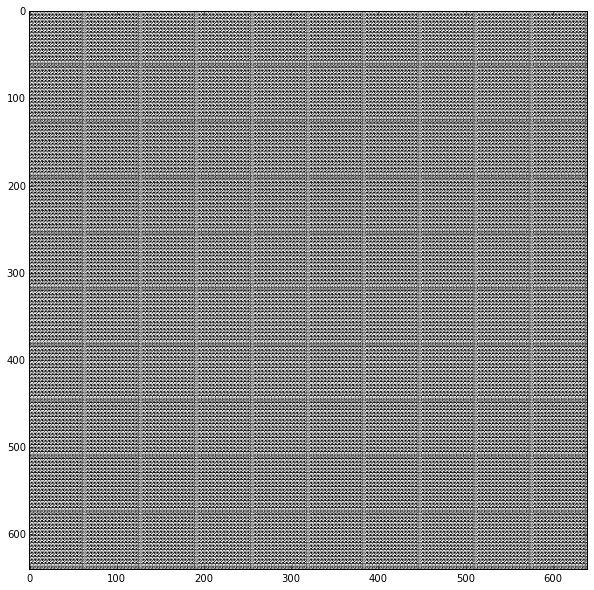

In [9]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()